In [10]:
%pip install openai pandas scikit-learn xgboost lightgbm sentence-transformers python-dotenv aiohttp

Defaulting to user installation because normal site-packages is not writeable

   --------------- ------------------------ 3/8 [attrs]
   --------------- ------------------------ 3/8 [attrs]
   ------------------------------ --------- 6/8 [aiosignal]
   ----------------------------------- ---- 7/8 [aiohttp]
   ----------------------------------- ---- 7/8 [aiohttp]
   ----------------------------------- ---- 7/8 [aiohttp]
   ----------------------------------- ---- 7/8 [aiohttp]
   ---------------------------------------- 8/8 [aiohttp]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Core data handling
import polars as pl
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ML & preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.decomposition import PCA
import xgboost as xgb
from lightgbm import LGBMRegressor, LGBMClassifier

# Embeddings
from sentence_transformers import SentenceTransformer
import torch

# Dimensionality reduction
import umap

# Optional: SQL-style exploration
import duckdb


### Load Embedded Bridge Dataset
Loads the previously saved `merged_1_filtered_embedded.csv` file into a DataFrame (`embedded_df`) for inspection or downstream embedding/modeling tasks.


In [3]:
embedded_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\merged_1_filtered_embedded.csv"
embedded_df = pd.read_csv(embedded_path)
print(embedded_df.shape)
embedded_df

(478, 50)


,STRUCTURE_ID,SUPPORT_TYPE,SPACING_PITCH_IN,COLUMNS_PILES_PER_BENT,COLUMNS_PILES_0_1,CLEAR_HEIGHT_FT,B_LONG_IN,B_TRANS_IN,L_H_LONG,L_H_TRANS,...,IMP_LEN_MT_076,DATE_OF_INSPECT_090,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_RECONSTRUCTED_106,PERCENT_ADT_TRUCK_109,FUTURE_ADT_114,DECK_AREA,embedding_text
0,0019133A,RectCol-Spiral,6,4.0,1.0,19.20,54.0,54.0,4.266667,4.266667,...,159.1,320,6890,1378,13781,0,2,23709,4168.42,Bridge latitude: 47.11858333 decimal degrees. ...
1,0019133D,RectCol-Spiral,4,2.0,1.0,24.60,48.0,48.0,6.150000,6.150000,...,104.9,1220,1789,358,3578,0,1,19153,1468.60,Bridge latitude: 47.12700556 decimal degrees. ...
2,0005582A,CircCol,12,4.0,1.0,34.40,36.0,36.0,11.466667,11.466667,...,89.6,1121,3234,647,6468,0,5,21372,1720.32,Bridge latitude: 47.14755833 decimal degrees. ...
3,0005523C,CircCol,12,1.0,0.0,18.00,60.0,60.0,3.600000,3.600000,...,96.6,1121,1775,355,3550,0,1,4420,1004.64,Bridge latitude: 47.15058056 decimal degrees. ...
4,0005651A,CircCol,12,1.0,0.0,25.20,72.0,72.0,4.200000,4.200000,...,86.3,1120,2377,475,4754,0,6,19158,1052.86,Bridge latitude: 47.15976389 decimal degrees. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,0014567C,CircCol,3.5,2.0,1.0,8.10,48.0,48.0,2.025000,2.025000,...,64.0,320,1680,336,3360,0,16,23413,774.40,Bridge latitude: 47.43122222 decimal degrees. ...
474,0014354A,CircCol,3.5,4.0,1.0,25.31,36.0,36.0,8.436667,8.436667,...,93.0,718,2867,573,5734,0,9,39584,1329.90,Bridge latitude: 47.30013889 decimal degrees. ...
475,0006068B,CircCol,Missing,5.0,1.0,28.40,36.0,36.0,9.466667,9.466667,...,93.6,718,3500,700,7000,1992,9,39584,1544.40,Bridge latitude: 47.30013889 decimal degrees. ...
476,0017936A,RectCol-Spiral,4,1.0,0.0,18.41,48.0,72.0,4.602500,3.068333,...,441.7,920,8404,1681,16808,0,12,22147,3886.96,Bridge latitude: 47.28811111 decimal degrees. ...


In [10]:
import os
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from dotenv import load_dotenv
from openai import OpenAI

# === 1️⃣ Setup ===
# Load .env from the same directory as the notebook
load_dotenv(dotenv_path=os.path.join(os.path.dirname(os.path.abspath("__file__")), ".env"))
api_key = os.getenv("OPENAI_API_KEY")

# Debug: Print the API key (first 10 chars only for security)
print(f"🔑 Loaded API key: {api_key[:10] if api_key else 'None'}...")

# Validate API key
if not api_key or api_key == "your-api-key-here" or not api_key.startswith("sk-"):
    raise ValueError(
        "❌ Invalid or missing OPENAI_API_KEY!\n"
        "Please create a .env file in the same directory as this notebook with:\n"
        "OPENAI_API_KEY=sk-proj-your-actual-key\n"
        f"Current directory: {os.getcwd()}"
    )

client = OpenAI(api_key=api_key)

if "STRUCTURE_ID" not in embedded_df.columns or "embedding_text" not in embedded_df.columns:
    raise KeyError("❌ Expected 'STRUCTURE_ID' and 'embedding_text' columns not found.")

# === 2️⃣ API call function ===
import re

def paraphrase_row(row, n=3, temperature=0.3):
    """Generate n paraphrases for one row via OpenAI."""
    struct_id = row["STRUCTURE_ID"]
    text = str(row["embedding_text"])

    prompt = f"""
    Produce {n} fluent paraphrases of the following bridge description.
    Keep every number and factual detail accurate.
    Label them 1., 2., 3. Each should vary word choice and sentence structure slightly.

    Description:
    {text}
    """

    try:
        response = client.responses.create(
            model="gpt-4o-mini",
            input=prompt,
            temperature=temperature,
            max_output_tokens=700,  # slightly higher, allow long answers
        )

        raw_output = response.output_text.strip()

        # ✅ Use regex to split by numbered labels (handles inline "1. text 2. text 3. text")
        parts = re.split(r"\s*\d\.\s*", raw_output)
        parts = [p.strip() for p in parts if p.strip()]

        # If less than n were found, pad with blanks
        parts = (parts + [""] * n)[:n]

        return {
            "STRUCTURE_ID": struct_id,
            "embedding_text": text,
            "paraphrase_1": parts[0],
            "paraphrase_2": parts[1],
            "paraphrase_3": parts[2],
        }

    except Exception as e:
        print(f"⚠️ Error for STRUCTURE_ID {struct_id}: {e}")
        time.sleep(2)
        return {
            "STRUCTURE_ID": struct_id,
            "embedding_text": text,
            "paraphrase_1": "",
            "paraphrase_2": "",
            "paraphrase_3": "",
        }


# === 3️⃣ Threaded batching ===
def batch_paraphrase(df, batch_size=20, max_workers=5):
    results = []
    total = len(df)
    for start in range(0, total, batch_size):
        batch = df.iloc[start:start + batch_size]
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(paraphrase_row, row): row for _, row in batch.iterrows()}
            for future in as_completed(futures):
                results.append(future.result())
        print(f"✅ Processed {min(start + batch_size, total)} / {total}")
        time.sleep(1.5)  # gentle throttle between batches
    return pd.DataFrame(results)

# === 4️⃣ Run ===
paraphrased_df = batch_paraphrase(embedded_df, batch_size=20, max_workers=5)

output_path = embedded_path.replace(".csv", "_paraphrased.csv")
paraphrased_df.to_csv(output_path, index=False)
print(f"\n🎯 Done! Saved paraphrases to {output_path}")


🔑 Loaded API key: sk-proj-sK...
✅ Processed 20 / 478
✅ Processed 40 / 478
✅ Processed 60 / 478
✅ Processed 80 / 478
✅ Processed 100 / 478
✅ Processed 120 / 478
✅ Processed 140 / 478
✅ Processed 160 / 478
✅ Processed 180 / 478
✅ Processed 200 / 478
✅ Processed 220 / 478
✅ Processed 240 / 478
✅ Processed 260 / 478
✅ Processed 280 / 478
✅ Processed 300 / 478
✅ Processed 320 / 478
✅ Processed 340 / 478
✅ Processed 360 / 478
✅ Processed 380 / 478
✅ Processed 400 / 478
✅ Processed 420 / 478
✅ Processed 440 / 478
✅ Processed 460 / 478
✅ Processed 478 / 478

🎯 Done! Saved paraphrases to C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_paraphrased_paraphrased.csv


In [4]:
embedded_path = "C:\\Users\\wongb\\Bridge-ML\\Bridge-ML-LLM-Embedding-Architecture\\merged_1_filtered_embedded_paraphrased_paraphrased.csv"
embedded_df_paraphrased = pd.read_csv(embedded_path)
random_entry = embedded_df_paraphrased['paraphrase_1'].sample(n=1).iloc[0]
print(f"Random sentence entry: {random_entry}")
embedded_df_paraphrased

Random sentence entry: **Bridge Latitude:** 4


,STRUCTURE_ID,embedding_text,paraphrase_1,paraphrase_2,paraphrase_3
0,0005523C,Bridge latitude: 47.15058056 decimal degrees. ...,The bridge is situated at a latitude of 4,15058056 decimal degrees and a longitude of -12,4991778 decimal degrees. It crosses over 'I-5'...
1,0019133D,Bridge latitude: 47.12700556 decimal degrees. ...,The bridge is located at a latitude of 4,12700556 decimal degrees and a longitude of -12,5440667 decimal degrees. It intersects with 'I...
2,0019133A,Bridge latitude: 47.11858333 decimal degrees. ...,The bridge is located at a latitude of 4,11858333 decimal degrees and a longitude of -12,5570833 decimal degrees. It intersects with 'I...
3,0005651A,Bridge latitude: 47.15976389 decimal degrees. ...,The bridge is located at a latitude of 4,15976389 decimal degrees and a longitude of -12,4835889 decimal degrees. It intersects with 'I...
4,0005582A,Bridge latitude: 47.14755833 decimal degrees. ...,The bridge is located at a latitude of 4,14755833 and a longitude of -12,504419
...,...,...,...,...,...
473,0014567C,Bridge latitude: 47.43122222 decimal degrees. ...,The bridge is located at a latitude of 4,43122222 decimal degrees and a longitude of -12,9857778 decimal degrees. It crosses over 'CARE...
474,0014354A,Bridge latitude: 47.30013889 decimal degrees. ...,The bridge is situated at a latitude of 4,30013889 decimal degrees and a longitude of -12,18055 decimal degrees. It intersects with the ...
475,0017936A,Bridge latitude: 47.28811111 decimal degrees. ...,The bridge is situated at a latitude of 4,28811111 decimal degrees and a longitude of -12,3080833 decimal degrees. It intersects with th...
476,0006068B,Bridge latitude: 47.30013889 decimal degrees. ...,The bridge is situated at a latitude of 4,30013889 decimal degrees and a longitude of -12,1801111 decimal degrees. It intersects with th...


### Generate E5 Sentence Embeddings
Encodes each bridge’s descriptive text (`embedding_text`) into numerical vectors using the **`intfloat/e5-large-v2`** model for semantic similarity and downstream ML tasks.

**Workflow**
1. **Configuration** — Sets model name, batch size, device (`cuda` if available), and output paths.  
2. **Model Loading** — Initializes the E5 transformer model on the chosen device with appropriate precision (`float16` for GPU).  
3. **Input Preparation** — Adds `"passage: "` prefix to each text entry for optimal embedding performance (per E5 convention).  
4. **Encoding** — Converts all sentences into dense embeddings using `SentenceTransformer.encode()`.  
5. **Saving Outputs** —  
   - Stores embeddings as a NumPy `.npy` file for reuse.  
   - Optionally attaches embeddings to the DataFrame and saves a combined CSV.  
6. **Result** — Returns a DataFrame (`embedded_E5_df`) containing original data plus embedding vectors.

**Outputs**
- `.npy` file with dense embeddings  
- Optional CSV with `embedding_vector` column  
- Console logs summarizing encoding progress, model details, and output locations


In [3]:
from sentence_transformers import SentenceTransformer
import torch


# Confirm column presence
if "embedding_text" not in embedded_df.columns:
    raise ValueError("❌ Column 'embedding_text' not found. Please generate it first.")

# --- 2️⃣ Configuration Section ---
MODEL_NAME = "intfloat/e5-large-v2"
BATCH_SIZE = 32              # Adjust based on VRAM
OUTPUT_PATH = embedded_path.replace(".csv", "_E5_embedded.npy")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

print(f"🧠 Using model: {MODEL_NAME}")
print(f"⚙️ Device: {DEVICE}, dtype: {DTYPE}")
print(f"📊 Encoding {len(embedded_df)} rows...")

# --- 3️⃣ Load the embedding model ---
model = SentenceTransformer(MODEL_NAME, device=DEVICE)
model = model.to(DEVICE, dtype=DTYPE)

# --- 4️⃣ Prepare inputs with prefix (per E5 training format) ---
# E5 expects instruction prefix "passage: " for best performance
texts = ["passage: " + str(t) for t in embedded_df["embedding_text"].fillna("unknown")]

# --- 5️⃣ Encode all sentences into vectors ---
embeddings = model.encode(
    texts,
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False  # L2 normalization for cosine similarity use
)

print(f"✅ Embeddings generated: shape = {embeddings.shape}")

# --- 6️⃣ Save outputs ---
# Save as .npy for fast loading, and optionally merge into DataFrame
np.save(OUTPUT_PATH, embeddings)
print(f"💾 Saved embeddings to: {OUTPUT_PATH}")

# Optionally add to dataframe and save combined CSV (only if you want one file)
embedded_df["embedding_vector"] = embeddings.tolist()
csv_out = embedded_path.replace(".csv", "_E5_embedded_with_vectors.csv")
embedded_df.to_csv(csv_out, index=False)
print(f"📄 Combined CSV saved at: {csv_out}")

# --- 7️⃣ Return DataFrame in environment ---
embedded_E5_df = embedded_df.copy()
print("✅ DataFrame 'embedded_E5_df' ready in environment.")
embedded_E5_df



🧠 Using model: intfloat/e5-large-v2
⚙️ Device: cpu, dtype: torch.float32
📊 Encoding 478 rows...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

✅ Embeddings generated: shape = (478, 1024)
💾 Saved embeddings to: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_E5_embedded.npy
📄 Combined CSV saved at: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_E5_embedded_with_vectors.csv
✅ DataFrame 'embedded_E5_df' ready in environment.


,STRUCTURE_ID,SUPPORT_TYPE,SPACING_PITCH_IN,COLUMNS_PILES_PER_BENT,COLUMNS_PILES_0_1,CLEAR_HEIGHT_FT,B_LONG_IN,B_TRANS_IN,L_H_LONG,L_H_TRANS,...,DATE_OF_INSPECT_090,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_RECONSTRUCTED_106,PERCENT_ADT_TRUCK_109,FUTURE_ADT_114,DECK_AREA,embedding_text,embedding_vector
0,0019133A,RectCol-Spiral,6,4.0,1.0,19.20,54.0,54.0,4.266667,4.266667,...,320,6890,1378,13781,0,2,23709,4168.42,Bridge latitude: 47.11858333 decimal degrees. ...,"[0.008795017376542091, -0.03232565522193909, 0..."
1,0019133D,RectCol-Spiral,4,2.0,1.0,24.60,48.0,48.0,6.150000,6.150000,...,1220,1789,358,3578,0,1,19153,1468.60,Bridge latitude: 47.12700556 decimal degrees. ...,"[0.0064788400195539, -0.036737967282533646, 0...."
2,0005582A,CircCol,12,4.0,1.0,34.40,36.0,36.0,11.466667,11.466667,...,1121,3234,647,6468,0,5,21372,1720.32,Bridge latitude: 47.14755833 decimal degrees. ...,"[0.02227136306464672, -0.038574714213609695, 0..."
3,0005523C,CircCol,12,1.0,0.0,18.00,60.0,60.0,3.600000,3.600000,...,1121,1775,355,3550,0,1,4420,1004.64,Bridge latitude: 47.15058056 decimal degrees. ...,"[0.013752206228673458, -0.036940861493349075, ..."
4,0005651A,CircCol,12,1.0,0.0,25.20,72.0,72.0,4.200000,4.200000,...,1120,2377,475,4754,0,6,19158,1052.86,Bridge latitude: 47.15976389 decimal degrees. ...,"[0.015588168986141682, -0.04039354249835014, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,0014567C,CircCol,3.5,2.0,1.0,8.10,48.0,48.0,2.025000,2.025000,...,320,1680,336,3360,0,16,23413,774.40,Bridge latitude: 47.43122222 decimal degrees. ...,"[0.021120864897966385, -0.053270336240530014, ..."
474,0014354A,CircCol,3.5,4.0,1.0,25.31,36.0,36.0,8.436667,8.436667,...,718,2867,573,5734,0,9,39584,1329.90,Bridge latitude: 47.30013889 decimal degrees. ...,"[0.00944523885846138, -0.05025206506252289, 0...."
475,0006068B,CircCol,Missing,5.0,1.0,28.40,36.0,36.0,9.466667,9.466667,...,718,3500,700,7000,1992,9,39584,1544.40,Bridge latitude: 47.30013889 decimal degrees. ...,"[0.014906288124620914, -0.04875604435801506, 0..."
476,0017936A,RectCol-Spiral,4,1.0,0.0,18.41,48.0,72.0,4.602500,3.068333,...,920,8404,1681,16808,0,12,22147,3886.96,Bridge latitude: 47.28811111 decimal degrees. ...,"[0.019176790490746498, -0.05002068355679512, 0..."


In [4]:
# Load pre-computed E5 embeddings from saved .npy file
embeddings_npy_path = r"C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_E5_embedded.npy"
embeddings = np.load(embeddings_npy_path)
print(f"✅ Loaded embeddings from: {embeddings_npy_path}")
print(f"📊 Embedding shape: {embeddings.shape}")
print(f"🔢 Data type: {embeddings.dtype}")

✅ Loaded embeddings from: C:\Users\wongb\Bridge-ML\Bridge-ML-LLM-Embedding-Architecture\merged_1_filtered_embedded_E5_embedded.npy
📊 Embedding shape: (478, 1024)
🔢 Data type: float32


### Nonlinear Dimensionality Reduction
Apply UMAP to reduce the high-dimensional E5 embeddings to a lower-dimensional space while preserving local and global structure. This compressed representation can improve computational efficiency and reveal latent patterns in the bridge data.

In [5]:
import umap
from sklearn.manifold import TSNE

# --- Configuration ---
N_COMPONENTS = 50  # Target dimensionality (adjust based on needs)
UMAP_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
RANDOM_STATE = 42

print(f"📉 Original embedding shape: {embeddings.shape}")
print(f"🎯 Reducing to {N_COMPONENTS} dimensions using UMAP...")

# --- Apply UMAP for nonlinear dimensionality reduction ---
reducer = umap.UMAP(
    n_components=N_COMPONENTS,
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric='cosine',
    random_state=RANDOM_STATE,
    verbose=True
)

embeddings_reduced = reducer.fit_transform(embeddings)

print(f"✅ Reduced embedding shape: {embeddings_reduced.shape}")
print(f"📊 Dimensionality reduction: {embeddings.shape[1]} → {embeddings_reduced.shape[1]}")

# Store for downstream analysis
embeddings_for_analysis = embeddings_reduced

📉 Original embedding shape: (478, 1024)
🎯 Reducing to 50 dimensions using UMAP...
UMAP(angular_rp_forest=True, metric='cosine', n_components=50, n_jobs=1, random_state=42, verbose=True)
Sat Nov 15 15:27:24 2025 Construct fuzzy simplicial set


C:\Users\wongb\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sat Nov 15 15:27:24 2025 Finding Nearest Neighbors
Sat Nov 15 15:27:28 2025 Finished Nearest Neighbor Search
Sat Nov 15 15:27:28 2025 Finished Nearest Neighbor Search
Sat Nov 15 15:27:29 2025 Construct embedding
Sat Nov 15 15:27:29 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Nov 15 15:27:31 2025 Finished embedding
✅ Reduced embedding shape: (478, 50)
📊 Dimensionality reduction: 1024 → 50
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Nov 15 15:27:31 2025 Finished embedding
✅ Reduced embedding shape: (478, 50)
📊 Dimensionality reduction: 1024 → 50


In [6]:
print(embeddings_for_analysis.shape, embeddings_for_analysis.dtype)
import numpy as np
norms = np.linalg.norm(embeddings_for_analysis, axis=1)
print("Mean norm:", np.mean(norms), "Std:", np.std(norms))
dim_var = embeddings_for_analysis.var(axis=0)
print("Min/Mean/Max variance across dims:",
      dim_var.min(), dim_var.mean(), dim_var.max())

(478, 50) float32
Mean norm: 42.777122 Std: 0.69335335
Min/Mean/Max variance across dims: 0.020143373 0.14573437 0.73164755


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

sample = embeddings_for_analysis[:100]
sim_matrix = cosine_similarity(sample)
np.fill_diagonal(sim_matrix, np.nan)
print("Mean similarity:", np.nanmean(sim_matrix),
      "Std:", np.nanstd(sim_matrix))

Mean similarity: 0.99878573 Std: 0.0013461319


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings_for_analysis)
print("Cluster distribution:", np.bincount(labels))

Cluster distribution: [ 93 176  43  26 140]


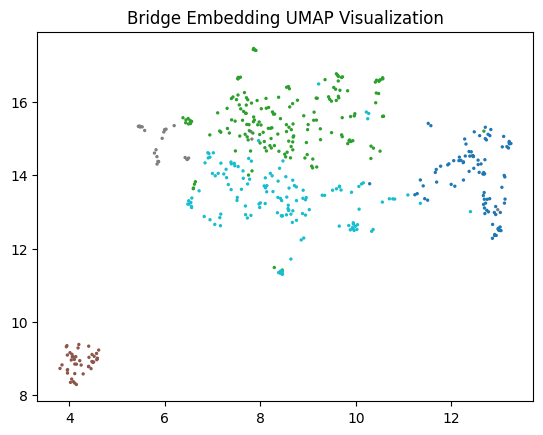

In [ ]:
import matplotlib.pyplot as plt

# Further reduce to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', n_components=2, random_state=42).fit_transform(embeddings_for_analysis)
plt.scatter(umap_2d[:,0], umap_2d[:,1], s=2, c=labels, cmap='tab10')
plt.title("Bridge Embedding UMAP Visualization (2D)")
plt.show()